@ author: ODD_team

#Distance Estimator
To estimate the real distance(unit: meter) of the object

__Input__: Bounding box coordinates(xmin, ymin, xmax, ymax)   
__Output__: 3D location z of carmera coordinates(z_loc)

## Load Module

In [1]:
# import module
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
#import category_encoders as ce
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader 
from sklearn.preprocessing import StandardScaler
from custom_datasets import CustomDataset
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder

In [2]:
# cd to ./weights
os.makedirs('./weights', exist_ok=True)

## Dataset

In [3]:
# get data set
df_train = pd.read_csv('../datasets/iou1_train.csv')
df_valid = pd.read_csv('../datasets/iou1_valid.csv')
df_test = pd.read_csv('../datasets/iou1_test.csv')

In [4]:
# sort the z_loc values
df_train['zloc'].sort_values()

19668    -1.87
15486     1.35
299       1.38
17113     1.41
21012     1.45
         ...  
6595     85.38
4955     85.70
7375     86.18
16783    86.24
18461    94.44
Name: zloc, Length: 21616, dtype: float64

In [5]:
#df_train = df_train[df_train['zloc'] > 0]
#df_valid = df_valid[df_valid['zloc'] > 0]
#df_test = df_test[df_test['zloc'] > 0]

In [6]:
#check the class
df_train['class'].unique()

array(['car', 'train', 'person', 'Misc', 'truck', 'bicycle'], dtype=object)

In [7]:
# onehot encoding(dummy var)
class_dummy = pd.get_dummies(df_train['class'])
df_train = pd.concat([df_train, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_valid['class'])
df_valid = pd.concat([df_valid, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_test['class'])
df_test = pd.concat([df_test, class_dummy], axis=1)

In [8]:
# TrVd
#df_train = pd.concat([df_train, df_valid], axis=0)

In [9]:
# encoding
le = LabelEncoder()
train_label = le.fit_transform(df_train['class'])
df_train['class_num'] = train_label

valid_label = le.fit_transform(df_valid['class'])
df_valid['class_num'] = valid_label

test_label = le.fit_transform(df_test['class'])
df_test['class_num'] = test_label

In [10]:
# see the info of df
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21616 entries, 0 to 21615
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         21616 non-null  object 
 1   class            21616 non-null  object 
 2   xmin             21616 non-null  float64
 3   ymin             21616 non-null  float64
 4   xmax             21616 non-null  float64
 5   ymax             21616 non-null  float64
 6   angle            21616 non-null  float64
 7   zloc             21616 non-null  float64
 8   weather          21616 non-null  object 
 9   iou              21616 non-null  float64
 10  depth_y          21616 non-null  int64  
 11  depth_min        21616 non-null  float64
 12  depth_mean       21616 non-null  float64
 13  depth_x          21616 non-null  int64  
 14  depth_median     21616 non-null  float64
 15  depth_max        21616 non-null  float64
 16  depth_mean_trim  21616 non-null  float64
 17  width       

In [11]:

variable = ['xmin','ymin','xmax','ymax','width', 'height', 'depth_mean_trim', 'depth_mean','depth_median','Misc', 'bicycle', 'car', 'person', 'train', 'truck']
val_length = len(variable)
batch_sz = 24
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# train
train_dataset = CustomDataset(df_train, variable, scaler=True, train=True, onehot=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
# train_sclaer
scaler_train = train_dataset.scaler

# valid
valid_dataset = CustomDataset(df_valid, variable, True, train=scaler_train, onehot=False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, shuffle=True)

# test
test_dataset = CustomDataset(df_test, variable, True, train=scaler_train, onehot=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(df_test), shuffle=False)

In [12]:
from pickle import dump
# scaler
dump(scaler_train, open('../model/lstm_scaler.pkl', 'wb'))

In [13]:
val_length # 15

15

In [14]:
# look the dataset
for idx, batch in enumerate(train_dataloader):
    if idx == 1:
        break
    print(batch[0])
    print(batch[0].shape)
    print(batch[0].dtype)
    print(batch[1])

tensor([[ 0.1518, -1.2831,  0.1005,  1.1516, -0.1564,  1.6882, -0.9927, -1.0888,
         -0.9912, -0.0784, -0.0482, -2.3530,  2.7976, -0.0839, -0.1578],
        [ 0.5185,  0.0236,  0.2524, -0.8336, -0.8084, -0.8740,  1.1544,  1.0482,
          1.1573, -0.0784, -0.0482,  0.4250, -0.3575, -0.0839, -0.1578],
        [-0.8662,  0.4029, -0.9222, -0.3612, -0.1594, -0.5297, -0.3202, -0.4071,
         -0.3162, -0.0784, -0.0482,  0.4250, -0.3575, -0.0839, -0.1578],
        [-0.2987,  0.3034, -0.4796, -0.8634, -0.5425, -1.0125,  1.1807,  1.0207,
          1.1880, -0.0784, -0.0482,  0.4250, -0.3575, -0.0839, -0.1578],
        [-1.7821,  0.7048, -1.3201,  0.7692,  1.4129,  0.5271, -0.9082, -0.9444,
         -0.9070, -0.0784, -0.0482,  0.4250, -0.3575, -0.0839, -0.1578],
        [ 1.0745, -1.5877,  1.0321,  2.2954, -0.1396,  2.9921, -1.2479, -1.2895,
         -1.2537, -0.0784, -0.0482, -2.3530,  2.7976, -0.0839, -0.1578],
        [-1.2671,  0.8376, -1.3482, -0.2581, -0.2307, -0.5899, -0.5049, -0.3

## Modeling

In [15]:
# zloc estimator model
class Zloc_Estimaotor(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim=1):
        super().__init__()
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=False)
        
        #Layer
        layersize=[306, 154, 76] # 294, 146, 72
        layerlist= []
        n_in=hidden_dim
        for i in layersize:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU())
            #layerlist.append(nn.BatchNorm1d(i))
            #layerlist.append(nn.Dropout(0.1))
            n_in=i           
        layerlist.append(nn.Linear(layersize[-1],1))
        #layerlist.append(nn.Sigmoid())
        
        self.fc=nn.Sequential(*layerlist)

        
    def forward(self, x):
        out, hn = self.rnn(x)
        output = self.fc(out[:,-1])
        return output

In [16]:
# another model(differ version)
class Zloc_Estimaotor_s(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        #Layer
        layersize=[32,64,128,256,128,64,32]
        layerlist= []
        n_in=input_dim
        for i in layersize:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU())
            #layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(0.1))
            n_in=i           
        layerlist.append(nn.Linear(layersize[-1],1))
        #layerlist.append(nn.Sigmoid())
        
        self.fc=nn.Sequential(*layerlist)

        
    def forward(self, x):
        #out, hn = self.rnn(x)
        output = self.fc(x)
        return output

## Make  variable

In [17]:

import torch.nn.init as init
#def weight_init(m):
#    if isinstance(m, nn.Linear): # nn.Linear에 있는 가중치에만 적용
#        init.kaiming_uniform_(m.weight.data) # He initialization

# variable 
input_dim = val_length
hidden_dim = 612 # 612
layer_dim = 3
        
model = Zloc_Estimaotor(input_dim, hidden_dim, layer_dim)
#model = Zloc_Estimaotor_s(input_dim)
#model.apply(weight_init)
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.5,
                                                       patience = 10,
                                                       mode='min', # 우리는 낮아지는 값을 기대
                                                       verbose=True,
                                                       min_lr=5e-5)
from early_stopping import EarlyStopping
early_stopping = EarlyStopping(70, verbose=True)   

model.to(device)

Zloc_Estimaotor(
  (rnn): LSTM(15, 612, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=612, out_features=306, bias=True)
    (1): ReLU()
    (2): Linear(in_features=306, out_features=154, bias=True)
    (3): ReLU()
    (4): Linear(in_features=154, out_features=76, bias=True)
    (5): ReLU()
    (6): Linear(in_features=76, out_features=1, bias=True)
  )
)

In [18]:
# train parameters
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameter(model) # 5686657

7789001

## Make Train, Valid function

In [19]:
# train function
def train(model, train_dataloader, idx_interval):
    model.train()
    
    train_loss = 0
    train_rmse = 0
    
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        inp = batch[0].reshape(len(batch[0]),1,-1)
        
        prediction = model(inp.to(device))
        loss = loss_fn(prediction, batch[1].to(device)).cpu()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        if idx % idx_interval == 0:
            print("Train Epoch: {} [{}/{}] \t Train Loss(MAE): {:.4f} \t Train RMAE: {:.4f}".format(epoch, batch_sz*(idx+1), \
                                                                            len(train_dataloader)*batch_sz, \
                                                                            loss.item(), np.sqrt(loss.item())))
    
    train_loss /= len(train_dataloader)
    train_rmse = np.sqrt(train_loss)
        
    return train_loss, train_rmse
#return loss and trainrmse

In [20]:
# eval function
def evaluate(model, valid_dataloader):
    model.eval()
    
    valid_loss = 0
    valid_rmse = 0
    
    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            inp = batch[0].reshape(len(batch[0]),1,-1)
            predictions = model(inp.to(device))
            loss = loss_fn(predictions, batch[1].to(device)).cpu()
            valid_loss += loss.item()
            
    valid_loss /= len(valid_dataloader)
    valid_rmse = np.sqrt(valid_loss)
    
    return valid_loss,valid_rmse

## Train and Validation

In [21]:
# training
Epoch = 1000
best_mae = 99999
best_train_mae = 99999

train_mae_list = []
valid_mae_list = []


for epoch in range(1,(Epoch+1)):
    train_mae, train_rmae = train(model, train_dataloader, 200)
    valid_mae, valid_rmae = evaluate(model, valid_dataloader)

    print("[Epoch: {} \t Valid MAE: {:.4f}".format(epoch, valid_mae))
    print("[Epoch: {} \t Train MAE: {:.4f}".format(epoch, train_mae))
    
    scheduler.step(valid_mae)       
    # Save model
    if valid_mae < best_mae:
        path = "./weights/ODD_LSTM_612_iou4_V3.pth"
        torch.save(model.state_dict(), path) # 모델의 가중치만 저장 구조는 저장 x..?
        best_mae = valid_mae
        best_train_mae = train_mae
        
    train_mae_list.append(train_mae)
    valid_mae_list.append(valid_mae)
    
    early_stopping(valid_mae, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Train Epoch: 1 [24/21624] 	 Train Loss(MAE): 22.4112 	 Train RMAE: 4.7340
Train Epoch: 1 [4824/21624] 	 Train Loss(MAE): 1.2139 	 Train RMAE: 1.1018
Train Epoch: 1 [9624/21624] 	 Train Loss(MAE): 1.6973 	 Train RMAE: 1.3028
Train Epoch: 1 [14424/21624] 	 Train Loss(MAE): 3.1844 	 Train RMAE: 1.7845
Train Epoch: 1 [19224/21624] 	 Train Loss(MAE): 3.3470 	 Train RMAE: 1.8295
[Epoch: 1 	 Valid MAE: 3.0837
[Epoch: 1 	 Train MAE: 2.9499
Validation loss decreased (inf --> 3.083686).  Saving model ...
Train Epoch: 2 [24/21624] 	 Train Loss(MAE): 4.0201 	 Train RMAE: 2.0050
Train Epoch: 2 [4824/21624] 	 Train Loss(MAE): 2.3309 	 Train RMAE: 1.5267
Train Epoch: 2 [9624/21624] 	 Train Loss(MAE): 2.1785 	 Train RMAE: 1.4760
Train Epoch: 2 [14424/21624] 	 Train Loss(MAE): 1.7795 	 Train RMAE: 1.3340
Train Epoch: 2 [19224/21624] 	 Train Loss(MAE): 2.7119 	 Train RMAE: 1.6468
[Epoch: 2 	 Valid MAE: 1.8579
[Epoch: 2 	 Train MAE: 2.2910
Validation loss decreased (3.083686 --> 1.857936).  Saving model 

Train Epoch: 18 [4824/21624] 	 Train Loss(MAE): 1.5272 	 Train RMAE: 1.2358
Train Epoch: 18 [9624/21624] 	 Train Loss(MAE): 1.6252 	 Train RMAE: 1.2748
Train Epoch: 18 [14424/21624] 	 Train Loss(MAE): 2.0938 	 Train RMAE: 1.4470
Train Epoch: 18 [19224/21624] 	 Train Loss(MAE): 1.5200 	 Train RMAE: 1.2329
[Epoch: 18 	 Valid MAE: 2.0048
[Epoch: 18 	 Train MAE: 1.5267
EarlyStopping counter: 6 out of 70
Train Epoch: 19 [24/21624] 	 Train Loss(MAE): 1.8874 	 Train RMAE: 1.3738
Train Epoch: 19 [4824/21624] 	 Train Loss(MAE): 1.9135 	 Train RMAE: 1.3833
Train Epoch: 19 [9624/21624] 	 Train Loss(MAE): 1.1880 	 Train RMAE: 1.0899
Train Epoch: 19 [14424/21624] 	 Train Loss(MAE): 2.2134 	 Train RMAE: 1.4878
Train Epoch: 19 [19224/21624] 	 Train Loss(MAE): 1.7167 	 Train RMAE: 1.3102
[Epoch: 19 	 Valid MAE: 1.5140
[Epoch: 19 	 Train MAE: 1.5407
EarlyStopping counter: 7 out of 70
Train Epoch: 20 [24/21624] 	 Train Loss(MAE): 1.7972 	 Train RMAE: 1.3406
Train Epoch: 20 [4824/21624] 	 Train Loss(MAE)

Train Epoch: 35 [4824/21624] 	 Train Loss(MAE): 2.0757 	 Train RMAE: 1.4407
Train Epoch: 35 [9624/21624] 	 Train Loss(MAE): 2.8443 	 Train RMAE: 1.6865
Train Epoch: 35 [14424/21624] 	 Train Loss(MAE): 1.7764 	 Train RMAE: 1.3328
Train Epoch: 35 [19224/21624] 	 Train Loss(MAE): 1.7144 	 Train RMAE: 1.3094
[Epoch: 35 	 Valid MAE: 1.8093
[Epoch: 35 	 Train MAE: 1.3973
EarlyStopping counter: 8 out of 70
Train Epoch: 36 [24/21624] 	 Train Loss(MAE): 1.4621 	 Train RMAE: 1.2092
Train Epoch: 36 [4824/21624] 	 Train Loss(MAE): 1.1642 	 Train RMAE: 1.0790
Train Epoch: 36 [9624/21624] 	 Train Loss(MAE): 1.3726 	 Train RMAE: 1.1716
Train Epoch: 36 [14424/21624] 	 Train Loss(MAE): 0.8533 	 Train RMAE: 0.9237
Train Epoch: 36 [19224/21624] 	 Train Loss(MAE): 1.2776 	 Train RMAE: 1.1303
[Epoch: 36 	 Valid MAE: 1.3438
[Epoch: 36 	 Train MAE: 1.4026
Validation loss decreased (1.377523 --> 1.343825).  Saving model ...
Train Epoch: 37 [24/21624] 	 Train Loss(MAE): 1.0892 	 Train RMAE: 1.0436
Train Epoch:

Train Epoch: 52 [9624/21624] 	 Train Loss(MAE): 1.6659 	 Train RMAE: 1.2907
Train Epoch: 52 [14424/21624] 	 Train Loss(MAE): 1.3989 	 Train RMAE: 1.1827
Train Epoch: 52 [19224/21624] 	 Train Loss(MAE): 0.9638 	 Train RMAE: 0.9817
[Epoch: 52 	 Valid MAE: 1.3127
[Epoch: 52 	 Train MAE: 1.3339
Validation loss decreased (1.325854 --> 1.312743).  Saving model ...
Train Epoch: 53 [24/21624] 	 Train Loss(MAE): 1.6952 	 Train RMAE: 1.3020
Train Epoch: 53 [4824/21624] 	 Train Loss(MAE): 1.7891 	 Train RMAE: 1.3376
Train Epoch: 53 [9624/21624] 	 Train Loss(MAE): 2.1030 	 Train RMAE: 1.4502
Train Epoch: 53 [14424/21624] 	 Train Loss(MAE): 0.9204 	 Train RMAE: 0.9594
Train Epoch: 53 [19224/21624] 	 Train Loss(MAE): 1.6219 	 Train RMAE: 1.2736
[Epoch: 53 	 Valid MAE: 1.3228
[Epoch: 53 	 Train MAE: 1.3121
EarlyStopping counter: 1 out of 70
Train Epoch: 54 [24/21624] 	 Train Loss(MAE): 1.3843 	 Train RMAE: 1.1766
Train Epoch: 54 [4824/21624] 	 Train Loss(MAE): 2.0893 	 Train RMAE: 1.4454
Train Epoch:

Train Epoch: 69 [14424/21624] 	 Train Loss(MAE): 1.4185 	 Train RMAE: 1.1910
Train Epoch: 69 [19224/21624] 	 Train Loss(MAE): 1.2453 	 Train RMAE: 1.1159
[Epoch: 69 	 Valid MAE: 1.3076
[Epoch: 69 	 Train MAE: 1.2741
EarlyStopping counter: 10 out of 70
Train Epoch: 70 [24/21624] 	 Train Loss(MAE): 1.7739 	 Train RMAE: 1.3319
Train Epoch: 70 [4824/21624] 	 Train Loss(MAE): 1.0649 	 Train RMAE: 1.0319
Train Epoch: 70 [9624/21624] 	 Train Loss(MAE): 1.0400 	 Train RMAE: 1.0198
Train Epoch: 70 [14424/21624] 	 Train Loss(MAE): 1.0708 	 Train RMAE: 1.0348
Train Epoch: 70 [19224/21624] 	 Train Loss(MAE): 1.3536 	 Train RMAE: 1.1634
[Epoch: 70 	 Valid MAE: 1.2773
[Epoch: 70 	 Train MAE: 1.2721
Validation loss decreased (1.301957 --> 1.277284).  Saving model ...
Train Epoch: 71 [24/21624] 	 Train Loss(MAE): 0.7383 	 Train RMAE: 0.8592
Train Epoch: 71 [4824/21624] 	 Train Loss(MAE): 1.5178 	 Train RMAE: 1.2320
Train Epoch: 71 [9624/21624] 	 Train Loss(MAE): 1.2371 	 Train RMAE: 1.1123
Train Epoch

Train Epoch: 86 [19224/21624] 	 Train Loss(MAE): 1.4940 	 Train RMAE: 1.2223
[Epoch: 86 	 Valid MAE: 1.2889
[Epoch: 86 	 Train MAE: 1.2119
EarlyStopping counter: 9 out of 70
Train Epoch: 87 [24/21624] 	 Train Loss(MAE): 1.4141 	 Train RMAE: 1.1891
Train Epoch: 87 [4824/21624] 	 Train Loss(MAE): 1.1811 	 Train RMAE: 1.0868
Train Epoch: 87 [9624/21624] 	 Train Loss(MAE): 0.7405 	 Train RMAE: 0.8605
Train Epoch: 87 [14424/21624] 	 Train Loss(MAE): 1.2868 	 Train RMAE: 1.1344
Train Epoch: 87 [19224/21624] 	 Train Loss(MAE): 1.1372 	 Train RMAE: 1.0664
[Epoch: 87 	 Valid MAE: 1.3701
[Epoch: 87 	 Train MAE: 1.2146
EarlyStopping counter: 10 out of 70
Train Epoch: 88 [24/21624] 	 Train Loss(MAE): 0.8199 	 Train RMAE: 0.9055
Train Epoch: 88 [4824/21624] 	 Train Loss(MAE): 0.9978 	 Train RMAE: 0.9989
Train Epoch: 88 [9624/21624] 	 Train Loss(MAE): 1.0739 	 Train RMAE: 1.0363
Train Epoch: 88 [14424/21624] 	 Train Loss(MAE): 1.4505 	 Train RMAE: 1.2044
Train Epoch: 88 [19224/21624] 	 Train Loss(MA

Train Epoch: 103 [14424/21624] 	 Train Loss(MAE): 1.1591 	 Train RMAE: 1.0766
Train Epoch: 103 [19224/21624] 	 Train Loss(MAE): 1.3690 	 Train RMAE: 1.1701
[Epoch: 103 	 Valid MAE: 1.2445
[Epoch: 103 	 Train MAE: 1.0562
EarlyStopping counter: 5 out of 70
Train Epoch: 104 [24/21624] 	 Train Loss(MAE): 1.1834 	 Train RMAE: 1.0878
Train Epoch: 104 [4824/21624] 	 Train Loss(MAE): 0.5582 	 Train RMAE: 0.7471
Train Epoch: 104 [9624/21624] 	 Train Loss(MAE): 1.0385 	 Train RMAE: 1.0191
Train Epoch: 104 [14424/21624] 	 Train Loss(MAE): 0.9050 	 Train RMAE: 0.9513
Train Epoch: 104 [19224/21624] 	 Train Loss(MAE): 1.0278 	 Train RMAE: 1.0138
[Epoch: 104 	 Valid MAE: 1.2687
[Epoch: 104 	 Train MAE: 1.0557
EarlyStopping counter: 6 out of 70
Train Epoch: 105 [24/21624] 	 Train Loss(MAE): 1.1247 	 Train RMAE: 1.0605
Train Epoch: 105 [4824/21624] 	 Train Loss(MAE): 0.8108 	 Train RMAE: 0.9004
Train Epoch: 105 [9624/21624] 	 Train Loss(MAE): 1.0142 	 Train RMAE: 1.0071
Train Epoch: 105 [14424/21624] 	

Train Epoch: 120 [4824/21624] 	 Train Loss(MAE): 1.3971 	 Train RMAE: 1.1820
Train Epoch: 120 [9624/21624] 	 Train Loss(MAE): 0.7198 	 Train RMAE: 0.8484
Train Epoch: 120 [14424/21624] 	 Train Loss(MAE): 0.7185 	 Train RMAE: 0.8477
Train Epoch: 120 [19224/21624] 	 Train Loss(MAE): 0.7919 	 Train RMAE: 0.8899
[Epoch: 120 	 Valid MAE: 1.1954
[Epoch: 120 	 Train MAE: 0.9589
EarlyStopping counter: 5 out of 70
Train Epoch: 121 [24/21624] 	 Train Loss(MAE): 0.9048 	 Train RMAE: 0.9512
Train Epoch: 121 [4824/21624] 	 Train Loss(MAE): 0.6240 	 Train RMAE: 0.7900
Train Epoch: 121 [9624/21624] 	 Train Loss(MAE): 0.6362 	 Train RMAE: 0.7976
Train Epoch: 121 [14424/21624] 	 Train Loss(MAE): 0.7411 	 Train RMAE: 0.8609
Train Epoch: 121 [19224/21624] 	 Train Loss(MAE): 0.8784 	 Train RMAE: 0.9372
[Epoch: 121 	 Valid MAE: 1.1810
[Epoch: 121 	 Train MAE: 0.9566
Validation loss decreased (1.181162 --> 1.180999).  Saving model ...
Train Epoch: 122 [24/21624] 	 Train Loss(MAE): 0.7872 	 Train RMAE: 0.887

Train Epoch: 137 [4824/21624] 	 Train Loss(MAE): 0.7975 	 Train RMAE: 0.8930
Train Epoch: 137 [9624/21624] 	 Train Loss(MAE): 0.6244 	 Train RMAE: 0.7902
Train Epoch: 137 [14424/21624] 	 Train Loss(MAE): 0.7828 	 Train RMAE: 0.8848
Train Epoch: 137 [19224/21624] 	 Train Loss(MAE): 1.5298 	 Train RMAE: 1.2369
[Epoch: 137 	 Valid MAE: 1.1797
[Epoch: 137 	 Train MAE: 0.9283
Epoch 00137: reducing learning rate of group 0 to 6.2500e-04.
EarlyStopping counter: 11 out of 70
Train Epoch: 138 [24/21624] 	 Train Loss(MAE): 1.3544 	 Train RMAE: 1.1638
Train Epoch: 138 [4824/21624] 	 Train Loss(MAE): 1.2568 	 Train RMAE: 1.1211
Train Epoch: 138 [9624/21624] 	 Train Loss(MAE): 0.7520 	 Train RMAE: 0.8672
Train Epoch: 138 [14424/21624] 	 Train Loss(MAE): 1.3309 	 Train RMAE: 1.1536
Train Epoch: 138 [19224/21624] 	 Train Loss(MAE): 1.3529 	 Train RMAE: 1.1631
[Epoch: 138 	 Valid MAE: 1.1796
[Epoch: 138 	 Train MAE: 0.9011
EarlyStopping counter: 12 out of 70
Train Epoch: 139 [24/21624] 	 Train Loss(MA

Train Epoch: 154 [4824/21624] 	 Train Loss(MAE): 0.7296 	 Train RMAE: 0.8542
Train Epoch: 154 [9624/21624] 	 Train Loss(MAE): 2.1071 	 Train RMAE: 1.4516
Train Epoch: 154 [14424/21624] 	 Train Loss(MAE): 0.7556 	 Train RMAE: 0.8693
Train Epoch: 154 [19224/21624] 	 Train Loss(MAE): 0.9464 	 Train RMAE: 0.9729
[Epoch: 154 	 Valid MAE: 1.1839
[Epoch: 154 	 Train MAE: 0.8704
EarlyStopping counter: 7 out of 70
Train Epoch: 155 [24/21624] 	 Train Loss(MAE): 1.1877 	 Train RMAE: 1.0898
Train Epoch: 155 [4824/21624] 	 Train Loss(MAE): 1.0178 	 Train RMAE: 1.0089
Train Epoch: 155 [9624/21624] 	 Train Loss(MAE): 0.7675 	 Train RMAE: 0.8761
Train Epoch: 155 [14424/21624] 	 Train Loss(MAE): 1.6805 	 Train RMAE: 1.2963
Train Epoch: 155 [19224/21624] 	 Train Loss(MAE): 0.9121 	 Train RMAE: 0.9550
[Epoch: 155 	 Valid MAE: 1.1814
[Epoch: 155 	 Train MAE: 0.8689
EarlyStopping counter: 8 out of 70
Train Epoch: 156 [24/21624] 	 Train Loss(MAE): 0.7035 	 Train RMAE: 0.8388
Train Epoch: 156 [4824/21624] 	 

Train Epoch: 171 [4824/21624] 	 Train Loss(MAE): 0.7106 	 Train RMAE: 0.8430
Train Epoch: 171 [9624/21624] 	 Train Loss(MAE): 0.9131 	 Train RMAE: 0.9556
Train Epoch: 171 [14424/21624] 	 Train Loss(MAE): 0.7331 	 Train RMAE: 0.8562
Train Epoch: 171 [19224/21624] 	 Train Loss(MAE): 0.8780 	 Train RMAE: 0.9370
[Epoch: 171 	 Valid MAE: 1.1798
[Epoch: 171 	 Train MAE: 0.8229
EarlyStopping counter: 24 out of 70
Train Epoch: 172 [24/21624] 	 Train Loss(MAE): 1.2511 	 Train RMAE: 1.1185
Train Epoch: 172 [4824/21624] 	 Train Loss(MAE): 0.6425 	 Train RMAE: 0.8016
Train Epoch: 172 [9624/21624] 	 Train Loss(MAE): 1.2806 	 Train RMAE: 1.1316
Train Epoch: 172 [14424/21624] 	 Train Loss(MAE): 0.7062 	 Train RMAE: 0.8404
Train Epoch: 172 [19224/21624] 	 Train Loss(MAE): 0.7413 	 Train RMAE: 0.8610
[Epoch: 172 	 Valid MAE: 1.1818
[Epoch: 172 	 Train MAE: 0.8232
EarlyStopping counter: 25 out of 70
Train Epoch: 173 [24/21624] 	 Train Loss(MAE): 0.4333 	 Train RMAE: 0.6583
Train Epoch: 173 [4824/21624] 

Train Epoch: 188 [4824/21624] 	 Train Loss(MAE): 1.2574 	 Train RMAE: 1.1213
Train Epoch: 188 [9624/21624] 	 Train Loss(MAE): 1.3194 	 Train RMAE: 1.1486
Train Epoch: 188 [14424/21624] 	 Train Loss(MAE): 0.7808 	 Train RMAE: 0.8836
Train Epoch: 188 [19224/21624] 	 Train Loss(MAE): 0.6934 	 Train RMAE: 0.8327
[Epoch: 188 	 Valid MAE: 1.1854
[Epoch: 188 	 Train MAE: 0.8103
EarlyStopping counter: 41 out of 70
Train Epoch: 189 [24/21624] 	 Train Loss(MAE): 1.2475 	 Train RMAE: 1.1169
Train Epoch: 189 [4824/21624] 	 Train Loss(MAE): 0.6708 	 Train RMAE: 0.8191
Train Epoch: 189 [9624/21624] 	 Train Loss(MAE): 0.6907 	 Train RMAE: 0.8311
Train Epoch: 189 [14424/21624] 	 Train Loss(MAE): 0.7539 	 Train RMAE: 0.8683
Train Epoch: 189 [19224/21624] 	 Train Loss(MAE): 0.9872 	 Train RMAE: 0.9936
[Epoch: 189 	 Valid MAE: 1.1895
[Epoch: 189 	 Train MAE: 0.8103
EarlyStopping counter: 42 out of 70
Train Epoch: 190 [24/21624] 	 Train Loss(MAE): 0.7415 	 Train RMAE: 0.8611
Train Epoch: 190 [4824/21624] 

Train Epoch: 205 [4824/21624] 	 Train Loss(MAE): 0.8224 	 Train RMAE: 0.9069
Train Epoch: 205 [9624/21624] 	 Train Loss(MAE): 0.5205 	 Train RMAE: 0.7215
Train Epoch: 205 [14424/21624] 	 Train Loss(MAE): 0.9777 	 Train RMAE: 0.9888
Train Epoch: 205 [19224/21624] 	 Train Loss(MAE): 0.8444 	 Train RMAE: 0.9189
[Epoch: 205 	 Valid MAE: 1.1857
[Epoch: 205 	 Train MAE: 0.8052
EarlyStopping counter: 58 out of 70
Train Epoch: 206 [24/21624] 	 Train Loss(MAE): 0.5415 	 Train RMAE: 0.7358
Train Epoch: 206 [4824/21624] 	 Train Loss(MAE): 0.8644 	 Train RMAE: 0.9298
Train Epoch: 206 [9624/21624] 	 Train Loss(MAE): 0.9542 	 Train RMAE: 0.9769
Train Epoch: 206 [14424/21624] 	 Train Loss(MAE): 1.4756 	 Train RMAE: 1.2148
Train Epoch: 206 [19224/21624] 	 Train Loss(MAE): 1.1684 	 Train RMAE: 1.0809
[Epoch: 206 	 Valid MAE: 1.1862
[Epoch: 206 	 Train MAE: 0.8052
EarlyStopping counter: 59 out of 70
Train Epoch: 207 [24/21624] 	 Train Loss(MAE): 0.7102 	 Train RMAE: 0.8427
Train Epoch: 207 [4824/21624] 

In [59]:
# train result of mae
print('Valid best:',best_mae)
print('Train best:',best_train_mae)

Valid best: 1.1703902567382407
Train best: 0.8801284479380448


# Epoch visualization

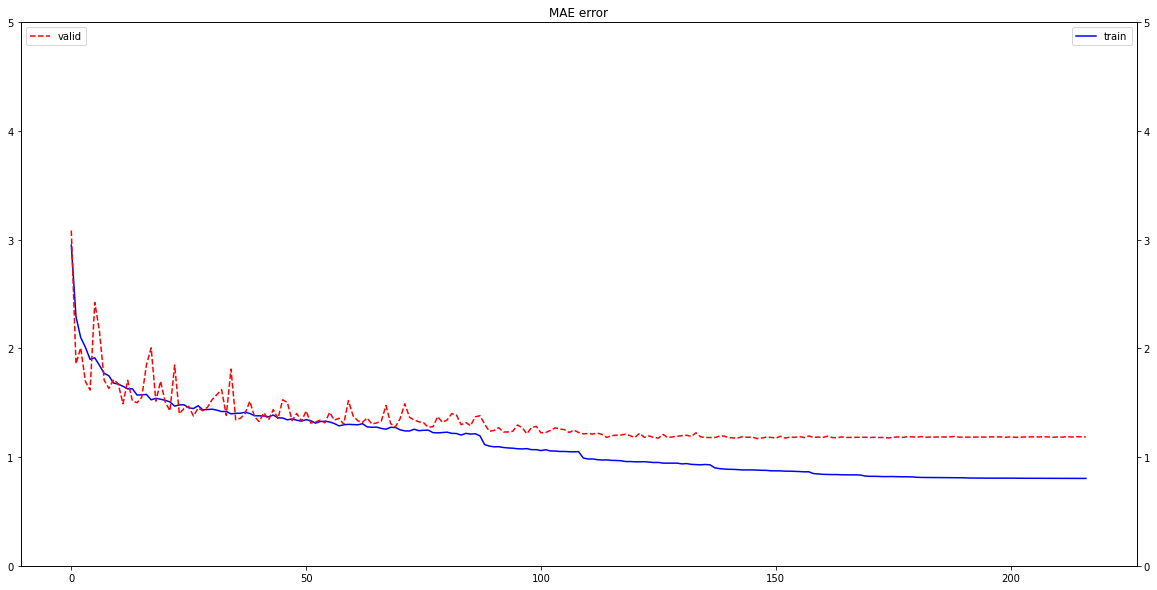

In [23]:
# visualizing
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(train_mae_list, ls='-', color='blue', label='train')
ax1.set_ylim(0,5)

ax2 = ax1.twinx()
ax2.plot(valid_mae_list, ls='--', color='red', label='valid')
ax2.set_ylim(0,5)

ax1.set_title('MAE error')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()


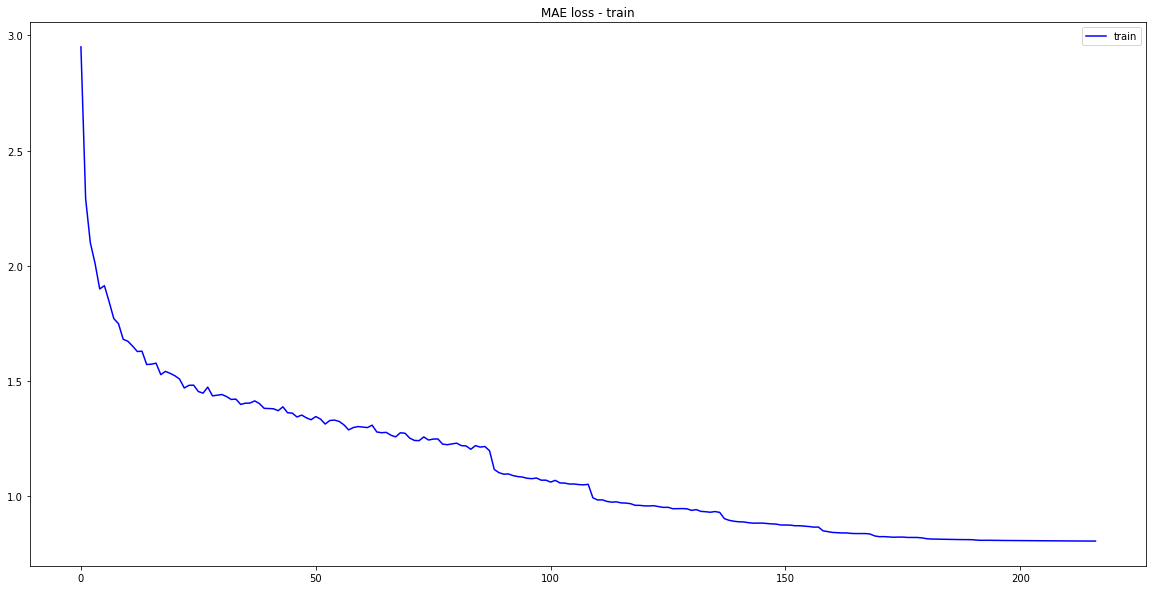

In [24]:
fig = plt.figure(figsize=(20,10))
plt.plot(train_mae_list, ls='-', color='blue', label='train')
plt.title('MAE loss - train')
plt.legend(loc='best', labels=['train'])

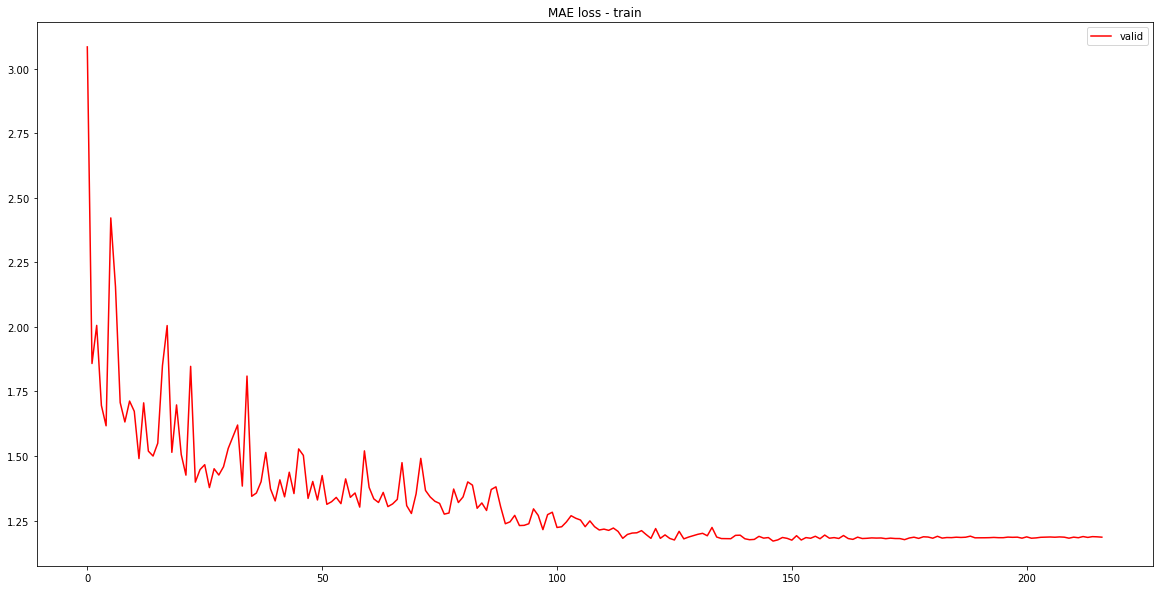

In [25]:
fig = plt.figure(figsize=(20,10))
plt.plot(valid_mae_list, ls='-', color='red', label='train')
plt.title('MAE loss - train')
plt.legend(loc='best', labels=['valid'])

# Best performance

In [107]:
# get weights
model = Zloc_Estimaotor(input_dim, hidden_dim,layer_dim)
model.load_state_dict(torch.load('./weights/ODD_LSTM_612_iou4_v2.pth'))
model.eval()
model.to(device)

Zloc_Estimaotor(
  (rnn): LSTM(15, 612, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=612, out_features=306, bias=True)
    (1): ReLU()
    (2): Linear(in_features=306, out_features=154, bias=True)
    (3): ReLU()
    (4): Linear(in_features=154, out_features=76, bias=True)
    (5): ReLU()
    (6): Linear(in_features=76, out_features=1, bias=True)
  )
)

# Predict Train

In [108]:
# predict value
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(df_train), shuffle=False)
for idx, batch in enumerate(train_dataloader):
    if idx == 1:
        break
    train_pred = batch[0]
predict_zloc = model(train_pred.reshape(-1,1,input_dim).to(device))

In [109]:
# get the result
df_train['predict'] = predict_zloc.cpu().detach().numpy()
df_train[['zloc','predict']].head(10)

,zloc,predict
0,33.26,33.634357
1,44.06,44.803944
2,48.93,49.145924
3,53.00,51.253986
4,15.60,16.046192
5,35.56,35.239002
6,17.76,17.926144
7,6.08,6.176448
8,33.44,33.429844
9,20.77,20.545490


In [110]:
# calculate
import numpy as np
abs0 = np.abs(df_train.zloc-df_train.predict)
abs0

0        0.374357
1        0.743944
2        0.215924
3        1.746014
4        0.446192
           ...   
21611    1.200453
21612    0.641326
21613    0.281702
21614    6.901861
21615    0.235201
Length: 21616, dtype: float64

In [111]:
# mae
sum(abs0/len(df_train))

0.8669704568871391

In [112]:
# rmse
np.mean(np.square(df_train['zloc']-df_train['predict']))**(1/2)

1.6474624371290816

In [113]:
# accuracy
func = np.sum(np.abs((df_train.predict - df_train.zloc))/(df_train.predict))
men = func/len(df_train)
1-men

0.9667855640799238

# Predict Valid

In [114]:
# valid set
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=len(df_train), shuffle=False)
for idx, batch in enumerate(valid_dataloader):
    if idx == 1:
        break
    valid_pred = batch[0]
predict_zloc = model(valid_pred.reshape(-1,1,input_dim).to(device))

In [115]:
# estimate valid
df_valid['predict'] = predict_zloc.cpu().detach().numpy()
df_valid[['zloc','predict']].head(10)

,zloc,predict
0,36.41,35.962666
1,37.96,36.591938
2,11.97,11.338449
3,41.95,53.708149
4,16.34,16.408024
5,4.65,4.963852
6,32.70,32.375813
7,42.93,44.615162
8,57.66,60.756001
9,9.71,9.069135


In [116]:
abs0 = np.abs(df_valid.zloc-df_valid.predict)
abs0

0        0.447334
1        1.368062
2        0.631551
3       11.758149
4        0.068024
          ...    
2697     1.167737
2698     0.007546
2699     0.135635
2700     0.129939
2701     0.290149
Length: 2702, dtype: float64

In [117]:
# mae
sum(abs0/len(df_valid))

1.185436720717492

In [118]:
#rmse
np.mean(np.square(df_valid['zloc']-df_valid['predict']))**(1/2)

2.057937547935697

In [119]:
# accuracy
func = np.sum(np.abs((df_valid.predict - df_valid.zloc))/(df_valid.predict))
men = func/len(df_valid)
1-men

0.9537928263376764

# Predict Test

In [120]:
test_mse, test_rmse = evaluate(model, test_dataloader)
print('Test MAE: {:4f} \t Test RMAE: {:4f}'.format(test_mse, test_rmse))

Test MAE: 1.209283 	 Test RMAE: 1.099674


In [121]:
# look dataset
for idx, batch in enumerate(test_dataloader):
    if idx == 1:
        break
    test_pred = batch[0]
predict_zloc = model(test_pred.reshape(-1,1,input_dim).to(device))

In [122]:
df_test['predict'] = predict_zloc.cpu().detach().numpy()
df_test[['zloc','predict']].head(10)

,zloc,predict
0,23.91,23.644657
1,22.08,22.386112
2,17.59,17.485653
3,15.68,15.802350
4,53.67,54.117176
5,14.61,14.410085
6,7.93,7.661138
7,26.44,27.247242
8,50.67,50.058369
9,56.22,58.018665


In [123]:
import numpy as np
abs0 = np.abs(df_test.zloc-df_test.predict)
abs0

0       0.265343
1       0.306112
2       0.104347
3       0.122350
4       0.447176
          ...   
2698    1.610410
2699    0.202098
2700    0.537847
2701    0.371189
2702    0.188979
Length: 2703, dtype: float64

In [124]:
# mae
sum(abs0/len(df_test))

1.2092829395637108

In [125]:
# rmse
np.mean(np.square(df_test['zloc']-df_test['predict']))**(1/2)

2.206189023507618

In [126]:
# accuracy
func = np.sum(np.abs((df_test.predict - df_test.zloc))/(df_test.predict))
men = func/len(df_test)
1-men

0.9507114587300285

### 구간 나눠서 정확도 계산해보기
## Divide by distance range and calculate it

In [127]:
first = df_test[df_test['zloc']<=10]
func1 = np.sum(np.abs((first.predict - first.zloc))/(first.predict))
men1 = func1/len(first)
1-men1

0.921595193073729

In [128]:
mask = (df_test['zloc']>=10) & (df_test['zloc']<20)
second = df_test[mask]
func2 = np.sum(np.abs((second.predict - second.zloc))/(second.predict))
men2 = func2/len(second)
1-men2

0.9612944661895336

In [129]:
mask = (df_test['zloc']>=20) & (df_test['zloc']<30)
third = df_test[mask]
func3 = np.sum(np.abs((third.predict - third.zloc))/(third.predict))
men3 = func3/len(third)
1-men3

0.9610578890776577

In [130]:
mask = (df_test['zloc']>=30) & (df_test['zloc']<40)
fourth = df_test[mask]
func4 = np.sum(np.abs((fourth.predict - fourth.zloc))/(fourth.predict))
men4 = func4/len(fourth)
1-men4

0.9550206496470354

In [131]:
mask = (df_test['zloc']>=40) & (df_test['zloc']<50)
fifth = df_test[mask]
func5 = np.sum(np.abs((fifth.predict - fifth.zloc))/(fifth.predict))
men5 = func5/len(fifth)
1-men5

0.9522999226957969

In [132]:
mask = (df_test['zloc']>=50) & (df_test['zloc']<60)
sixth = df_test[mask]
func6 = np.sum(np.abs((sixth.predict - sixth.zloc))/(sixth.predict))
men6 = func6/len(sixth)
1-men6

0.9473426068489499

In [133]:
mask = (df_test['zloc']>=60) & (df_test['zloc']<70)
seventh = df_test[mask]
func7 = np.sum(np.abs((seventh.predict - seventh.zloc))/(seventh.predict))
men7 = func7/len(seventh)
1-men7

0.9424140512906621

In [134]:
acc_list = []
for i in range(1,12):
    mask = (df_test['zloc']<i*10) & (df_test['zloc'] >= (i-1)*10)
    data = df_test[mask]
    value = np.sum(np.abs((data.predict - data.zloc))/(data.predict))
    output = value/len(data)
    acc_list.append(1-output)

C:\Users\Xiaopeng Yang\AppData\Local\Temp\ipykernel_13876\2504621056.py:6: RuntimeWarning: invalid value encountered in double_scalars
  output = value/len(data)


In [135]:
acc_list

[0.9215388982408211,
 0.9612944661895336,
 0.9610578890776577,
 0.9550206496470354,
 0.9522999226957969,
 0.9473426068489499,
 0.9424140512906621,
 0.948037302197223,
 0.9963098668151937,
 nan,
 nan]

# Visualization

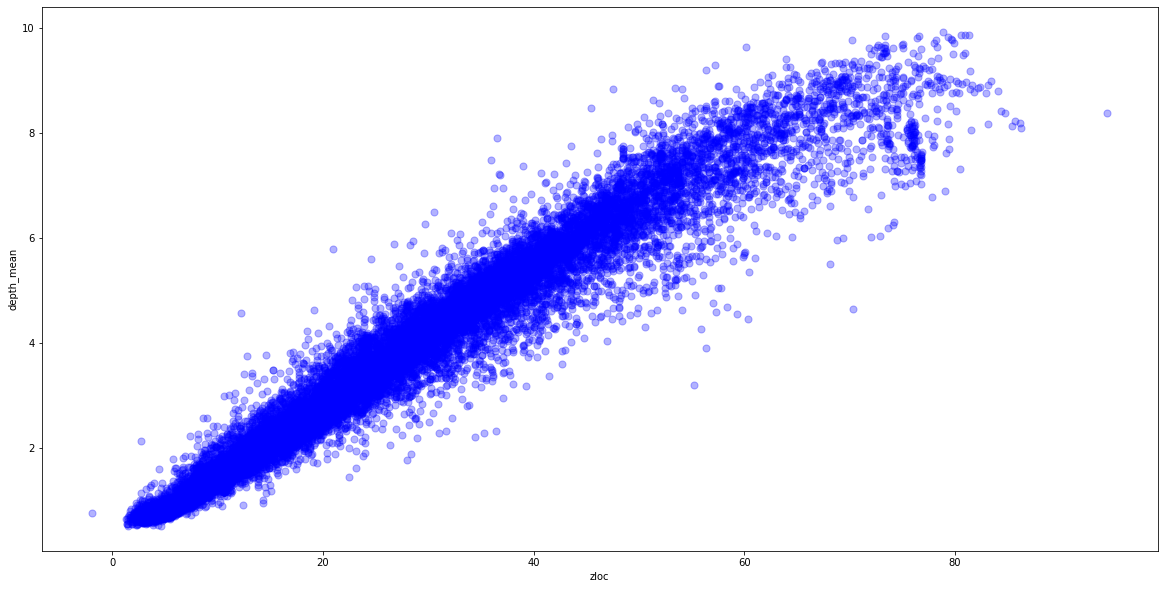

In [136]:
df_train.plot(kind='scatter', x='zloc', y='depth_mean', marker='o', alpha=0.3, s=50, figsize=(20,10), color='blue')
plt.show()

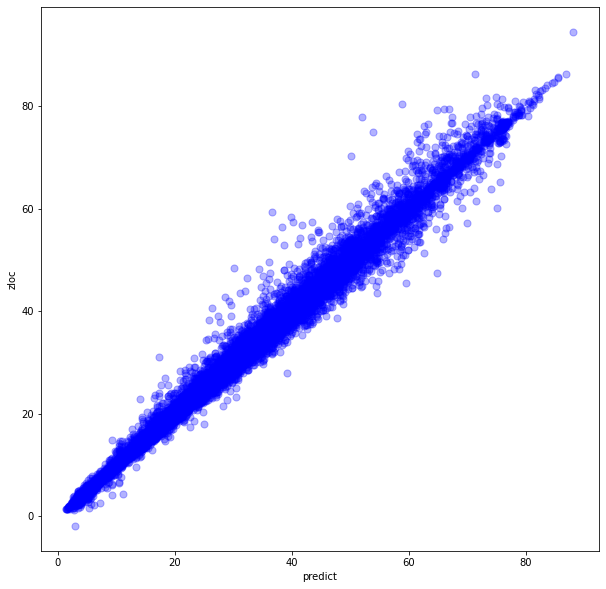

In [137]:
df_train.plot(kind='scatter', x='predict', y='zloc', marker='o', alpha=0.3, s=50, figsize=(10,10), color='blue')
plt.show()

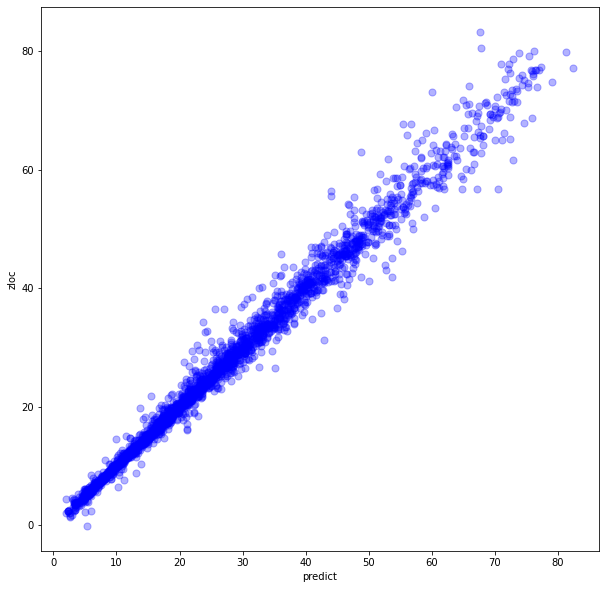

In [138]:
df_valid.plot(kind='scatter', x='predict', y='zloc', marker='o', alpha=0.3, s=50, figsize=(10,10), color='blue')
plt.show()

<AxesSubplot:xlabel='predict', ylabel='zloc'>

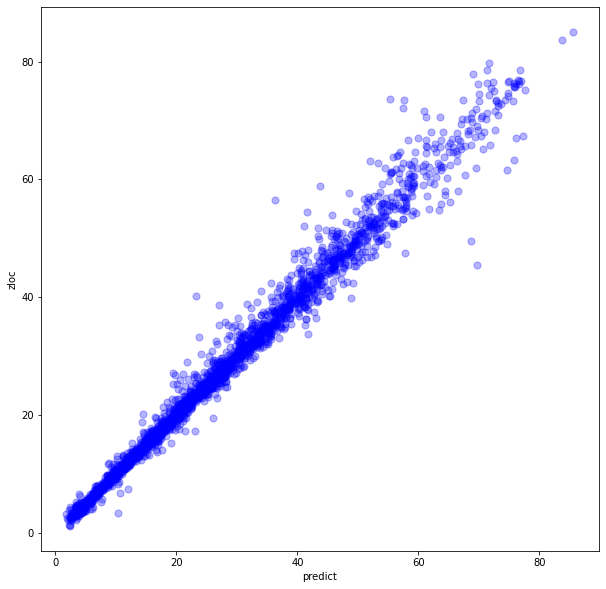

In [139]:
df_test.plot(kind='scatter', x='predict', y='zloc', marker='o', alpha=0.3, s=50, figsize=(10,10), color='blue')